In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
# compress the graph withing the code cell so that it is ftten optmially#
%matplotlib inline 


2025-09-16 11:46:58.490062: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 11:46:58.490459: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 11:46:58.541559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-16 11:47:00.339790: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

### READING ANIMELIST.CSV

In [2]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [3]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [4]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [5]:
len(rating_df)

4999999

#### DATA PROCESSING

more experienced user will help more in finding accuratings ratings as compare to user that have only watch 50 or 60 anime

In [6]:
n_ratings = rating_df["user_id"].value_counts()
# only those users that have rated more than 400 anime are included because they help in getting good anime ratings
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [7]:
len(rating_df)

3246641

In [8]:
min_rating =min(rating_df["rating"])
min_rating

0

In [9]:
max_rating =max(rating_df["rating"])
max_rating

10

In [10]:
avg_rating =np.mean(rating_df["rating"])
avg_rating

np.float64(4.122732695114736)

In [11]:
# scaling our feature to be in range 0 and 12. Doing it using min max scaling.
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [12]:
# checking duplicates
rating_df.duplicated().sum()

np.int64(0)

In [13]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [14]:
# getting unique user ids
user_ids = rating_df["user_id"].unique().tolist()
# encoding those users
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [15]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [16]:
n_users = len(user2user_encoded)

In [17]:
n_users

4203

In [18]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [19]:
# doing the same decoding for anime ids
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [21]:
n_anime = len(anime2anime_encoded)

In [22]:
n_anime

17149

In [23]:
# sampling the data
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [24]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [25]:
# getting encoded user and anime id
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [26]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [27]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [28]:
len(X_train)

3245641

In [29]:
len(X_test)

1000

In [30]:
type(X_train)

numpy.ndarray

In [31]:
#                 user            anime
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [32]:
type(X_test_array)

list

In [33]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [34]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [35]:
model = RecommenderNet()

2025-09-16 11:47:16.591531: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [38]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [39]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [40]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
 55/325 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.7992 - mae: 0.3819 - mse: 0.1968

KeyboardInterrupt: 

In [41]:
model.load_weights(checkpoint_filepath)

NameError: name 'history' is not defined

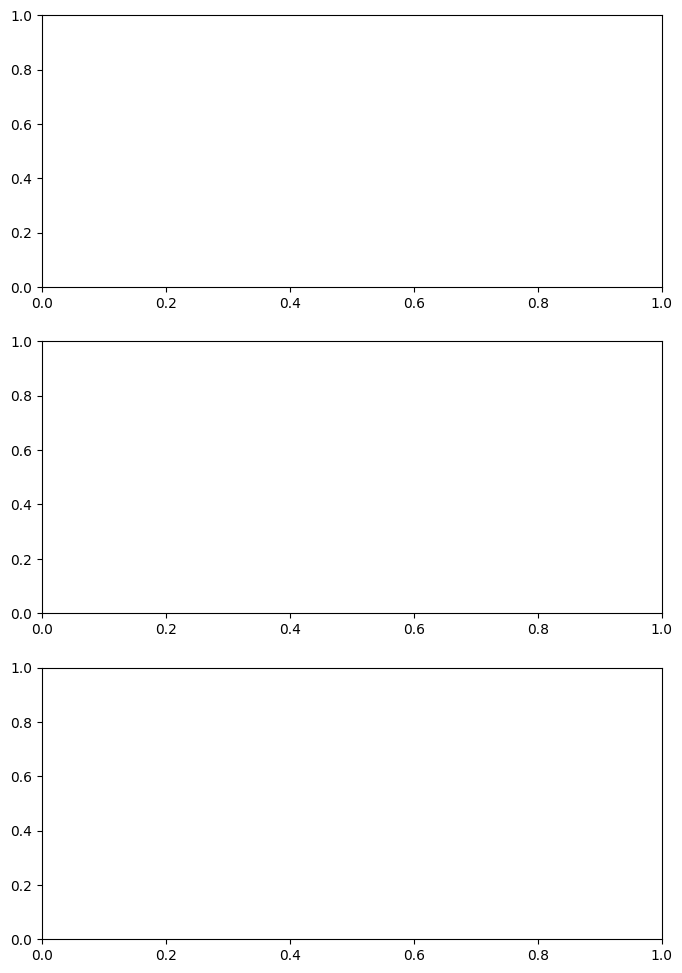

In [42]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [43]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [44]:
anime_weights = extract_weights("anime_embedding",model)

In [45]:
user_weights = extract_weights("user_embedding",model)

#### READING ANIME.CSV

In [46]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [47]:
df = df.replace("Unknown",np.nan)

In [48]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [49]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [50]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [51]:
getAnimeName(67)

'Basilisk'

In [52]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [53]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [54]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [55]:
df.head(5)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [56]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [57]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [58]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [59]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [60]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [61]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [62]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [63]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [64]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [65]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [66]:
pd.set_option("max_colwidth",None)

In [67]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [68]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    # return Frame
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [69]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Vicious,0.360784,Hentai
8,Ponsuke no Udekurabe,0.331322,Action
7,Fighting Beauty Wulong,0.321552,"Action, Ecchi, Martial Arts"
6,Spirit Guardians,0.313113,"Action, Fantasy"
5,"Watashitachi, Luck Logic-bu! 2",0.309638,"Game, Comedy, School"
4,Starmyu OVA,0.307902,"Music, Slice of Life, School"
3,Mama no Earring,0.300568,"Music, Kids"
2,Mobile Suit Gundam-san: Hiyoko Days ― Suisei Hiyoko to Fushigi na Ofuda,0.299074,"Comedy, Parody, Mecha"
1,Kobito to Ao Mushi,0.297865,"Kids, Music"
0,Nananin no Ayakashi: Chimi Chimi Mouryou!! Gendai Monogatari,0.291983,"Comedy, Supernatural"


### USER BASED RECOMMENDATION

In [70]:
def find_similar_users(user_id , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=user_id
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(user_id,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != user_id]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [71]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,15966,0.330209
8,13597,0.301762
7,10181,0.282703
6,14204,0.272055
5,5659,0.271470
4,16492,0.262038
3,4612,0.254811
2,2356,0.251676
1,2972,0.251508
0,3858,0.247031


In [72]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [73]:
from collections import defaultdict

In [74]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [75]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [76]:
x  = getAnimeFrame(1, df)

In [77]:
getFavGenre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [78]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [79]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




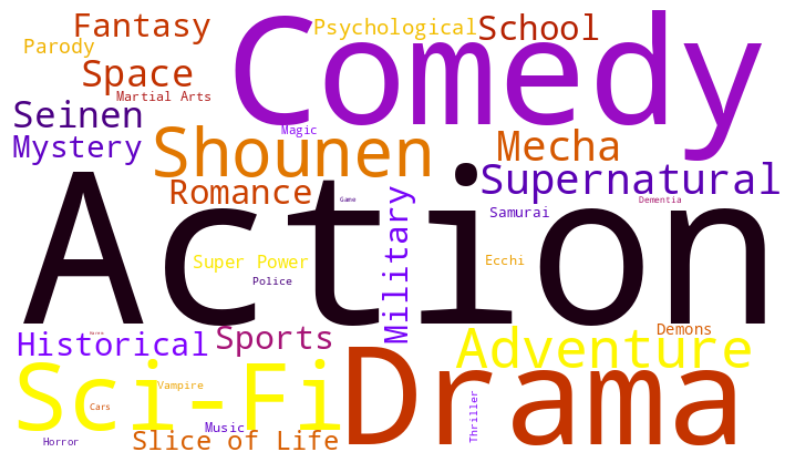

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [80]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [ ]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [86]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [87]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [91]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

                                        count
Code Geass:Lelouch of the Rebellion R2      8


,n,anime_name,Genres,Synopsis
0,8,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."


### HYBRID RECOMMENDER SYSTEM

In [ ]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)
    # print(sorted_animes)
    return [anime for anime , score in sorted_animes[:10]] 



In [93]:
hybrid_recommendation(11880)

                                        count
Code Geass:Lelouch of the Rebellion R2      8
Code Geass:Lelouch of the Rebellion         8
No Game, No Life                            8
Fate/Zero                                   7
Death Note                                  7
Daily Lives of High School Boys             7
Attack on Titan                             7
Steins;Gate                                 6
Spirited Away                               6
Demon Slayer:Kimetsu no Yaiba               6
['Code Geass:Lelouch of the Rebellion R2', 'Code Geass:Lelouch of the Rebellion', 'No Game, No Life', 'Fate/Zero', 'Death Note', 'Daily Lives of High School Boys', 'Attack on Titan', 'Steins;Gate', 'Spirited Away', 'Demon Slayer:Kimetsu no Yaiba']
[('Code Geass:Lelouch of the Rebellion R2', 0.5), ('Code Geass:Lelouch of the Rebellion', 0.5), ('No Game, No Life', 0.5), ('Fate/Zero', 0.5), ('Death Note', 0.5), ('Daily Lives of High School Boys', 0.5), ('Attack on Titan', 0.5), ('Steins;Gate'

['Code Geass:Lelouch of the Rebellion R2',
 'Code Geass:Lelouch of the Rebellion',
 'No Game, No Life',
 'Fate/Zero',
 'Death Note',
 'Daily Lives of High School Boys',
 'Attack on Titan',
 'Steins;Gate',
 'Spirited Away',
 'Demon Slayer:Kimetsu no Yaiba']